<a href="https://colab.research.google.com/github/Vinoth11111/A-B-Testing-Nykaa/blob/main/nykaa_a_b_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
np.random.seed(190)

In [3]:
groups = ['control','treatment']
df = pd.DataFrame({'user_id': range(1,100001),
                   'group': random.choices(groups,k=100000),
                   'converted': 0,
                   'order_value': 0
                   })

In [4]:
df['group'].value_counts()

,count
group,
control,50143
treatment,49857


In [5]:
df

,user_id,group,converted,order_value
0,1,treatment,0,0
1,2,control,0,0
2,3,control,0,0
3,4,treatment,0,0
4,5,treatment,0,0
...,...,...,...,...
99995,99996,control,0,0
99996,99997,control,0,0
99997,99998,treatment,0,0
99998,99999,treatment,0,0


In [6]:
def conversion(df):
  control = df['group'] == 'control'
  treatment = df['group'] == 'treatment'
  df.loc[control,'converted'] = np.random.binomial(1,0.03,control.sum())
  df.loc[treatment,'converted'] = np.random.binomial(1,0.028,treatment.sum())
  return df

In [7]:
df = conversion(df)

In [8]:
df

,user_id,group,converted,order_value
0,1,treatment,0,0
1,2,control,0,0
2,3,control,0,0
3,4,treatment,0,0
4,5,treatment,1,0
...,...,...,...,...
99995,99996,control,0,0
99996,99997,control,0,0
99997,99998,treatment,0,0
99998,99999,treatment,0,0


In [9]:
df['converted'].value_counts()

,count
converted,
0,97056
1,2944


In [10]:
def coversion_cal(df):
  contorl_con = df['converted'].loc[(df['group'] == 'control')]
  treatment_con = df['converted'].loc[(df['group'] == 'treatment')]
  control_conversion_rate = contorl_con.mean()
  treatment_conversion_rate = treatment_con.mean()
  return control_conversion_rate,treatment_conversion_rate


In [11]:
control_conversion_rate,treatment_conversion_rate = coversion_cal(df)
print('conversion rate of control is ',control_conversion_rate)
print('conversion rate of treatment is ',treatment_conversion_rate)

conversion rate of control is  0.03075204913946114
conversion rate of treatment is  0.028120424413823536


In [12]:
def add_order_value(df):
  control = df['group'] == 'control'
  treatment = df['group'] == 'treatment'
  control_conversion = df['converted'].loc[df['group'] == 'control'].sum()
  treatment_conversion = df['converted'].loc[df['group'] == 'treatment'].sum()
  sigma = 0.5
  df['order_value'].loc[(control) & (df['converted'] == 1)] = np.random.lognormal(mean=np.log(550)- (sigma**2/2),sigma=sigma,size = control_conversion)
  df['order_value'].loc[(treatment) & (df['converted'] == 1)] = np.random.lognormal(mean=np.log(610)-(sigma**2/2),sigma = sigma,size = treatment_conversion)
  return df

In [13]:
df = add_order_value(df)

/tmp/ipython-input-29461142.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['order_value'].loc[(control) & (df['converted'] == 1)] = np.random.lognormal(mean=np.log(550)- (sigma**2/2),sigma=sigma,size = control_conversion)
/tmp/ipytho

In [14]:
df.loc[df['converted'] == 1]

,user_id,group,converted,order_value
4,5,treatment,1,1194.145440
59,60,control,1,592.684416
104,105,control,1,241.233863
125,126,treatment,1,440.664299
367,368,control,1,560.957867
...,...,...,...,...
99887,99888,control,1,1024.618845
99905,99906,control,1,277.815253
99908,99909,treatment,1,402.359423
99930,99931,control,1,790.745600


In [15]:
aov_control = df['order_value'].loc[(df['group']=='control') & (df['converted'] == 1)].mean()
aov_treatment = df['order_value'].loc[(df['group']=='treatment') & (df['converted'] == 1)].mean()


In [16]:
print('average order value for control users is ', aov_control)
print('average order value for treatment users is ', aov_treatment)

average order value for control users is  553.0683213917679
average order value for treatment users is  612.3877374209914


In [17]:
df.reset_index(drop=True).to_csv('nykaa_ab_testing_dataset')

In [18]:
#let us assumes that we dont know anything about the data like conversion rate,aov etc
# conversion rate for both control and treatment.
control_conversion,treatment_conversion = df.groupby('group')['converted'].mean()

In [19]:
print(f'control conversion is {control_conversion*100:.3f}')
print(f'treatment conversion is {treatment_conversion*100:.3f}')

control conversion is 3.075
treatment conversion is 2.812


In [20]:
# average order value for each group,
# average order value is our metrics that we want to increase.
aov_control,aov_treatment = df[df['converted']==1].groupby('group')['order_value'].mean()

In [21]:
print(f'average order value in control group is {aov_control:.3f}')
print(f'average order value in treatment group is {aov_treatment:.3f}')

average order value in control group is 553.068
average order value in treatment group is 612.388


In [22]:
#Revernue per user,
# revenue per user is the guardrail metric that we want to take care of.
revenue_control,revenue_treatment = df.groupby('group')['order_value'].mean()

In [23]:
print(f'revenue per user in control group is {revenue_control:.3f}')
print(f'revenue per user in treatment group is {revenue_treatment:.3f}')

revenue per user in control group is 17.008
revenue per user in treatment group is 17.221


In [24]:
control_group = df[df['group'] == 'control']
treatment_group = df[df['group'] == 'treatment']

In [25]:
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import chi2_contingency

In [26]:
#checking for normal distribution,because the t_test assumes normal distribution.
stat,p_value = shapiro(control_group['order_value'])
print(f'p_value is {p_value:.3f}')
stat, p_value = shapiro(treatment_group['order_value'])
print(f"Treatment group normality p-value: {p_value}")

p_value is 0.000
Treatment group normality p-value: 8.708542694852314e-159


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 50143.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 49857.
  res = hypotest_fun_out(*samples, **kwds)


<Axes: xlabel='order_value', ylabel='Density'>

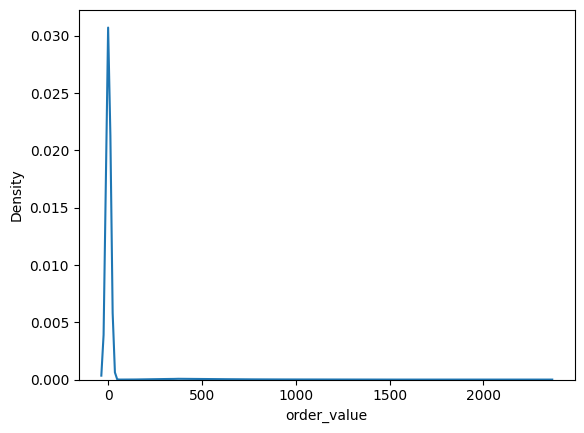

In [27]:
# since only small amount of the pepople convert we get positive kurtosis and not a normal distribution.
sns.kdeplot(control_group['order_value'])

<Axes: xlabel='order_value', ylabel='Density'>

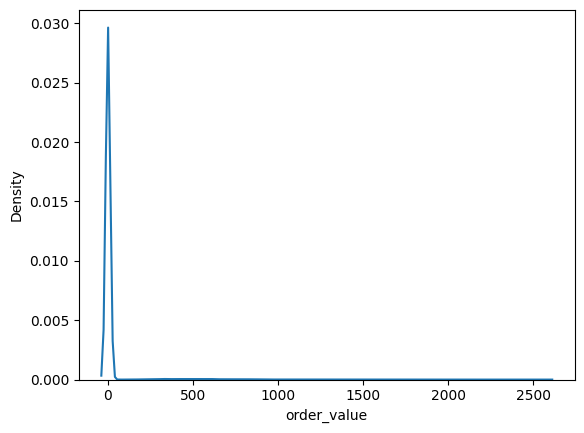

In [28]:
sns.kdeplot(treatment_group['order_value'],label='treatment')


In [29]:
#both p_value and distribution plot tells us right now our data is not normaly distributed .
# so we can't use t-test, because t_test assumes normal distribution.(but we can use them)

In [30]:
# if the data is even not normaly distributed, when the data is n> 50, we can use the t_test
# we trust centrel limit theorem.(n>50000)
# but we have to make sure we dont have any outliers in the data, because it alter mean of the group. t_test requries mean

In [31]:
print('control max value ',control_group['order_value'].max())
print('control min value ',control_group['order_value'].min())
print('treatment_group max value ',treatment_group['order_value'].max())
print('treatment_group min value ',treatment_group['order_value'].min())


control max value  2329.846915962757
control min value  0.0
treatment_group max value  2573.3337454139364
treatment_group min value  0.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7ec866b941d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ec842282c90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ec842282480>],
 'medians': [<matplotlib.lines.Line2D at 0x7ec842283260>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ec842283560>],
 'means': []}

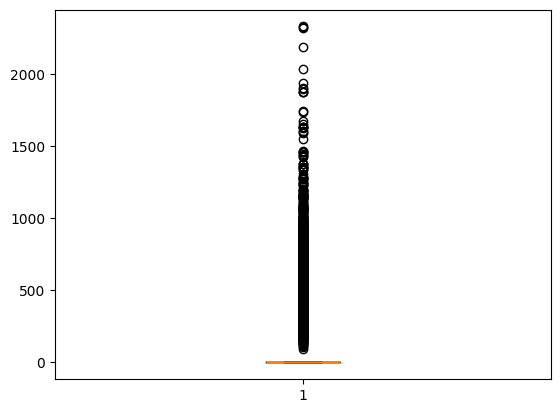

In [32]:
plt.boxplot(control_group['order_value'])

In [33]:
print('control avg value ',control_group['order_value'].mean())
print('control avg value ',treatment_group['order_value'].mean())


control avg value  17.007984196918933
control avg value  17.2206030820994


In [34]:
# we are setting, equal variance = False, because it reduce one assumption,
# it change the default student t_test  to welch's t_test.
# welch's t_test assumes that there is no need for equal variance.it assumes only normal distribution.(from above plot and the max values, their likely unequal variance)
# in our case that, in treatment group people trend to spend more so ,its safe to use welch's t_test.

stat_value,p_value = ttest_ind(control_group['order_value'],treatment_group['order_value'],equal_var=False,alternative='two-sided')
print(f'p_value is {p_value:.3f}')
alpha = 0.05
if p_value < alpha:
  print('we reject the null hypothesis,there is statistical significants')
else:
  print('we fail to reject the null hypothesis,there is a no statistical significants')

p_value is 0.763
we fail to reject the null hypothesis,there is a no statistical significants


In [35]:
stat_value

np.float64(-0.3019356285862178)

as we can see from p_value(0.64) there is no statistical significant between control and treatment. and if the null hypothesis is true we expect to see 64% of the times just by random(luck🍀).

right now our stats value for test is -0.45, which means that the signal is very small compared to the  noice which does not create enough evidence to see the statistical difference.

# mean difference between control and treatment is only 0.45% of the noice, noice very high will lead to submerge the mean difference

stats_value = mean diff in the group/standard error

variance diff in the group = mean of control - mean of treatment

#here we have negative value which mean treatment variance is higher than control variance.

if the range is bound greater than -2.4 or 3.1(imagenary) we will have p_value < 0.05. stats_value find the evidence and for p_value, if stats value is huge the P_value will be less, lead to alternative hypothesis

In [36]:
chi_data = pd.crosstab(df['group'],df['converted'])
chi_data

converted,0,1
group,,
control,48601,1542
treatment,48455,1402


In [37]:
# chi-square test tell us is there any significant in the conversion
chi2,p_val,dof,expected = chi2_contingency(chi_data)
print(f'p_value is {p_val:.3f}')
alpha = 0.05
if p_val < alpha:
  print('there is a statistical significant difference in conversion rate between both control and treatment group')
else:
  print('conversion rate same for control and treatment group')

p_value is 0.015
there is a statistical significant difference in conversion rate between both control and treatment group


In [38]:
print(chi2) #how much observed values devited from actual values.
# here we have 5 which is moderate deviation.

5.967573145028042


In [39]:
dof # dof = no of row -1 * no of col-1 2-1 * 2-1 = 1, its used for calculating p_value

1

In [40]:
expected # expected value if both treatment and control have same conversion rate.

array([[48666.79008,  1476.20992],
       [48389.20992,  1467.79008]])

In [46]:
import statsmodels.stats.api as sms

In [47]:
#creating descriptive statistics for each group
d1 = sms.DescrStatsW(control_group['order_value'])
d2 = sms.DescrStatsW(treatment_group['order_value'])
cm = sms.CompareMeans(d1,d2)
lower_ci,upper_ci = cm.tconfint_diff(alternative = 'two-sided', usevar='unequal', alpha = 0.05)#usevar = 'unequal is for welch's test

In [48]:
print(f'confidence interval for the difference in RPU: {lower_ci:.4f}, {upper_ci:.4f}')

confidence interval for the difference in RPU: -1.5928 to 1.1676


as we can see from the CI(confidence interval) result our values range in -1.5928 , 1.1676,we can determin that
* loss per user is  -1.5928.
* gain per user is 1.1676.

our ci bound is -1.5928, 1.1676 and it contain 0 in it, which mean there is no statistical significant that treatment group perform better than control.

#final interpretation:
If the 95% confidence interval contains 0, the result is NOT statistically significant.

If the 95% confidence interval does NOT contain 0 (e.g., [+0.50, +2.50]), the result IS statistically significant.

In [58]:
from scipy.stats import beta
# baysien a/b testing.
#finding the converion rate for control and treatment group.
control_users = df[df['group'] == 'control'].shape[0]
treatment_user = df[df['group'] == 'treatment'].shape[0]
# finding how many user converted
control_conversion_count = df[df['group']=='control']['converted'].sum()
treatment_conversion_count = df[df['group']=='treatment']['converted'].sum()

# createing prior information
a_prior,b_prior = 1,1
# calculating posterior
control_postier = beta(a_prior+control_conversion_count,b_prior+control_users-control_conversion_count)
treatment_postier = beta(a_prior + treatment_conversion_count,b_prior+treatment_user-treatment_conversion_count)

control_sample = control_postier.rvs(10000)
treatment_sample = treatment_postier.rvs(10000)

test_ci = (treatment_sample > control_sample).mean()

print(f"Probability that treatment CR is better than control CR: {test_ci * 100:.2f}%")

Probability that treatment CR is better than control CR: 0.67%


In [55]:
control_conversion_count = df[df['group']=='control']['converted'].sum()

In [56]:
control_conversion_count

np.int64(1542)

In [54]:
control_users

50143